# MODELLO PER PM
I modelli attuali hanno un mse di 144 in PM2.5 e RMSE 21.9 in PM10 (http://www.ec4macs.eu/content/report/EC4MACS_Publications/MR_Final%20in%20pdf/Chimere_Methodologies_Final.pdf) usano CHIMERE e NINFA

Il modello coi sensori diffusi non risente del downwash tra le case, capisce i microfenomeni usando la statistica.

In [1]:
import datetime
import warnings

import tensorflow as tf
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.stats as measures

In [2]:
# Nasconde i warning errati di pandas ma anche tutti gli altri, attenzione agli aggiornamenti di tensorflow
warnings.simplefilter("ignore")

In [3]:
style.use('bmh')
sns.set_style("ticks")
sns.set_style("darkgrid")
cmap = sns.diverging_palette(220, 20, as_cmap = True)

In [4]:
df_pm = pd.read_json("dati_milano/pm10_11_18.json")
df_temp = pd.read_json("dati_milano/temperature_11_18.json")
df_umi = pd.read_json("dati_milano/umidita_11_18.json")
df_prec = pd.read_json("dati_milano/precipitazioni_11_18.json")

In [5]:
#df = df_pm.shift(1)
df = df_pm
df["temp"] = df_temp
df["umi"] = df_umi
df["prec"] = df_prec
#df["weekend"] = (df.index.weekday > 4) * 1
df["weekday"] = df.index.weekday
df["mese"] = df.index.month

In [6]:
df = df.dropna()

In [7]:
df.head()

,pm10,temp,umi,prec,weekday,mese
2012-01-12,106,4.5,77.1,0.0,3,1
2012-01-13,88,4.9,78.4,0.0,4,1
2012-01-14,96,0.2,91.6,0.2,5,1
2012-01-15,87,-2.6,95.1,0.2,6,1
2012-01-16,97,-1.6,88.7,0.0,0,1


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pm10,2469.0,38.326043,24.450977,4.0,21.0,31.0,49.0,171.0
temp,2469.0,14.807250,8.246669,-6.6,7.7,15.0,21.7,32.1
umi,2469.0,69.719320,15.287999,15.7,58.0,69.8,81.8,100.0
prec,2469.0,2.971081,8.047349,0.0,0.0,0.0,1.0,119.8
weekday,2469.0,3.001215,2.000506,0.0,1.0,3.0,5.0,6.0
mese,2469.0,6.428514,3.395859,1.0,3.0,6.0,9.0,12.0


## Correlazioni:
Le correlazioni rivelano una relazione abbastanza forte tra i pm10 e la temperatura e l'umidità.
Sembra inoltre essere più rilevante il **_numero di giorni senza pioggia_** rispetto all'effettivo ammontare della pioggia.

In [9]:
df.corr()

,pm10,temp,umi,prec,weekday,mese
pm10,1.000000,-0.561905,0.371262,-0.183460,-0.002510,-0.020510
temp,-0.561905,1.000000,-0.511789,-0.067390,0.005361,0.205313
umi,0.371262,-0.511789,1.000000,0.347604,0.026695,0.159614
prec,-0.183460,-0.067390,0.347604,1.000000,0.027033,-0.004066
weekday,-0.002510,0.005361,0.026695,0.027033,1.000000,0.000579
mese,-0.020510,0.205313,0.159614,-0.004066,0.000579,1.000000


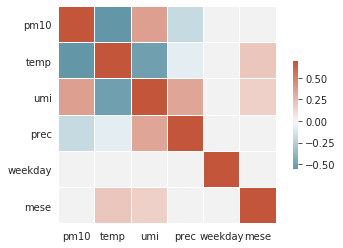

In [10]:
sns.heatmap(df.corr(), cmap = cmap, vmax = .7, center = 0,
            square = True, linewidths = .1, cbar_kws = {"shrink": .5})

Proof che la distribuzione dei valori di pm10 non è random, ed è possibile creare un modello valido:

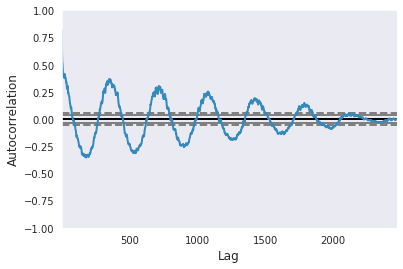

In [11]:
autocorrelation_plot(df.pm10)

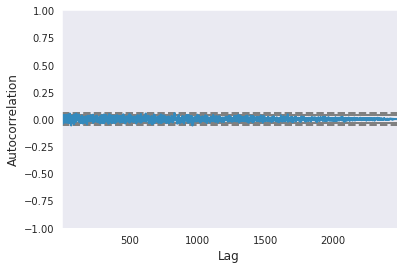

In [12]:
autocorrelation_plot(np.random.randint(df.pm10.max(), size=df.pm10.size))

## Dati ingegnerizzati

### Giorni senza pioggia

In [13]:
df["no_pioggia"] = df.prec
df.no_pioggia.loc[df.no_pioggia != 0] = -1
df.no_pioggia.loc[df.no_pioggia == 0] = 1
df.no_pioggia.loc[df.no_pioggia == -1] = 0

In [14]:
#Sottraggo al vettore con somma cumulata i giorni con valori ripetuti
somma = df.no_pioggia.cumsum()
correttore = somma.copy()
correttore.loc[~somma.duplicated()] = np.nan
correttore.iloc[0] = 0
correttore = correttore.fillna(method = "ffill")
df.no_pioggia = (somma - correttore).astype(int)

In [15]:
df.head()

,pm10,temp,umi,prec,weekday,mese,no_pioggia
2012-01-12,106,4.5,77.1,0.0,3,1,1
2012-01-13,88,4.9,78.4,0.0,4,1,2
2012-01-14,96,0.2,91.6,0.2,5,1,0
2012-01-15,87,-2.6,95.1,0.2,6,1,0
2012-01-16,97,-1.6,88.7,0.0,0,1,1


In [16]:
df.corr()

,pm10,temp,umi,prec,weekday,mese,no_pioggia
pm10,1.000000,-0.561905,0.371262,-0.183460,-0.002510,-0.020510,0.099256
temp,-0.561905,1.000000,-0.511789,-0.067390,0.005361,0.205313,0.279184
umi,0.371262,-0.511789,1.000000,0.347604,0.026695,0.159614,-0.428437
prec,-0.183460,-0.067390,0.347604,1.000000,0.027033,-0.004066,-0.257305
weekday,-0.002510,0.005361,0.026695,0.027033,1.000000,0.000579,0.011881
mese,-0.020510,0.205313,0.159614,-0.004066,0.000579,1.000000,-0.046716
no_pioggia,0.099256,0.279184,-0.428437,-0.257305,0.011881,-0.046716,1.000000


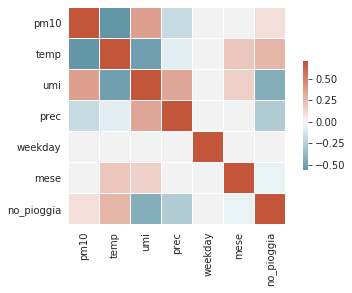

In [17]:
sns.heatmap(df.corr(), cmap = cmap, vmax = .7, center = 0,
            square = True, linewidths = .1, cbar_kws = {"shrink": .5})

## Studio valori notevoli

In [18]:
f"Massimo PM10: {df.pm10.max()} il {df.pm10.idxmax()}"

'Massimo PM10: 171 il 2017-01-31 00:00:00'

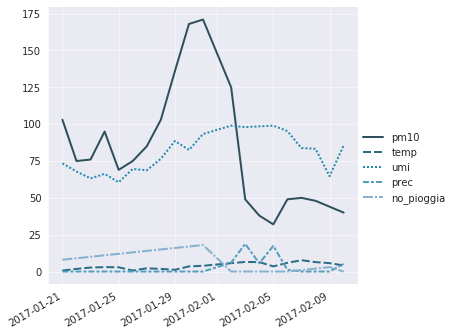

In [19]:
palette = sns.color_palette("PuBuGn_d", 5)

g = sns.relplot(kind="line",
                palette = palette,
                data = 
                df.loc[
                    df.pm10.idxmax() - datetime.timedelta(days=10) : 
                    df.pm10.idxmax() + datetime.timedelta(days=10)
                ].drop(["weekday", "mese"], axis = 1)
               )
g.fig.autofmt_xdate()

In [20]:
f"Minimo PM10: {df.pm10.min()} il {df.pm10.idxmin()}"

'Minimo PM10: 4 il 2012-07-22 00:00:00'

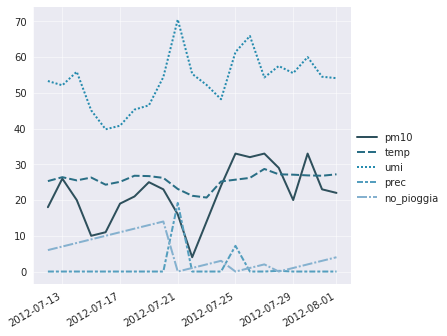

In [21]:
g = sns.relplot(kind="line",
                palette = palette,
                data = 
                df.loc[
                    df.pm10.idxmin() - datetime.timedelta(days=10) : 
                    df.pm10.idxmin() + datetime.timedelta(days=10)
                ].drop(["weekday", "mese"], axis = 1)
               )
g.fig.autofmt_xdate()

In [22]:
f"Il periodo più lungo senza pioggia è finito il {df.no_pioggia.idxmax()}, {df.no_pioggia.max()} giorni"

'Il periodo più lungo senza pioggia è finito il 2015-07-24 00:00:00, 31 giorni'

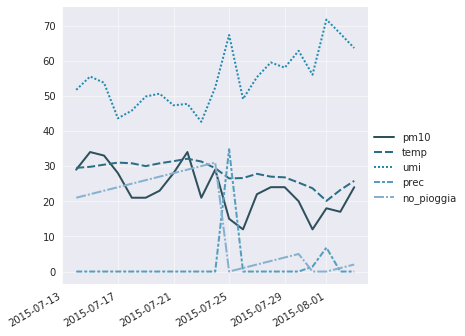

In [23]:
g = sns.relplot(kind="line",
                palette = palette,
                data = 
                df.loc[
                        df.no_pioggia.idxmax() - datetime.timedelta(days=10) : 
                        df.no_pioggia.idxmax() + datetime.timedelta(days=10)
                    ].drop(["weekday", "mese"], axis = 1)
               )
g.fig.autofmt_xdate()

## Normalizzazioni

### Media mobile a mov_av giorni
Il modello è meno volatile senza intaccare i test, il risultato sarà meno preciso nella predizione del valore esatto ma prevederà meglio il trend.

In [24]:
#Pandas risponde con un warning sbagliato ATTENZIONE
mov_av = 2
df["pm10"] = df["pm10"].rolling(mov_av).mean()
df = df.iloc[mov_av - 1:]
df["pm10"] = df["pm10"].astype(int)

In [25]:
df.prec.max()

119.8

In [26]:
df.temp.min()

-6.6

In [27]:
df.temp.max()

32.1

### Normalizzo tra 0 e 100:
Ma solo precipitazioni, temperatura e umidità. I PM sono circa già nel range.

In [28]:
df.prec = (100 * (df.prec / df.prec.max())).astype(int)
df.temp = (100 * ((df.temp - df.temp.min())/ df.temp.max())).astype(int)
df.umi = df.umi.astype(int)

In [29]:
df.head()

,pm10,temp,umi,prec,weekday,mese,no_pioggia
2012-01-13,97,35,78,0,4,1,2
2012-01-14,92,21,91,0,5,1,0
2012-01-15,91,12,95,0,6,1,0
2012-01-16,92,15,88,0,0,1,1
2012-01-17,101,14,87,0,1,1,2


### One hot nei giorni della settimana

In [30]:
giorno_one_hot = pd.get_dummies(df.weekday)

In [31]:
df = pd.concat([df.drop(["weekday"], axis = 1), giorno_one_hot], axis = 1)

In [32]:
df.head()

,pm10,temp,umi,prec,mese,no_pioggia,0,1,2,3,4,5,6
2012-01-13,97,35,78,0,1,2,0,0,0,0,1,0,0
2012-01-14,92,21,91,0,1,0,0,0,0,0,0,1,0
2012-01-15,91,12,95,0,1,0,0,0,0,0,0,0,1
2012-01-16,92,15,88,0,1,1,1,0,0,0,0,0,0
2012-01-17,101,14,87,0,1,2,0,1,0,0,0,0,0


## Training

In [33]:
f"Con {df.shape[0]} campioni."

'Con 2468 campioni.'

In [34]:
n_steps = 250
n_inputs = len(df.columns)
n_neurons = 100
n_outputs = 1

In [35]:
validation = df.iloc[-(n_steps + 1):]
df = df.iloc[:-(n_steps)]

In [36]:
resolution = 1
lun = len(df) - n_steps

def time_series(t):
    array = []
    for x in t:
        array.append(df.iloc[x].values)
    return np.array(array).copy()

def next_batch(batch_size, n_steps):
    t0 = np.random.randint(lun, size = (batch_size, 1))
    Ts = t0 + np.arange(0, n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, n_inputs), ys[:, 1:, 0].reshape(-1, n_steps, 1) #, 1

In [37]:
model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(units = n_neurons, activation = "relu", return_sequences=True),
        tf.keras.layers.GRU(units = int(n_neurons / 2), activation = "relu", return_sequences=True),
        tf.keras.layers.GRU(units = int(n_neurons / 3), activation = "relu", return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
        tf.keras.layers.Dense(1),
        #tf.keras.layers.Reshape((-1, n_outputs))
       ])

In [38]:
def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [39]:
datagen = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=df[:-1].values, targets=df[1:].values, length=n_steps)

In [40]:
import ast
np.array(ast.literal_eval(datagen.get_config()["data"])).shape

(2217, 13)

### LSTM si blocca a mse: 1200

Problema di vanishing gradient risolto da GRU, perchè? Bho.

Il MinMax performa peggio del mse in generale, l'errore massimo risulta perfino essere minore con l'mse,
anche se non in modo significativo (27 - 30)

Il onehot sui mesi non fa variare il risultato.  -> con profondità 3 il risultato peggiora sensibilmente, il onehot sui mesi è da scartare.

Aumentando la profondità con onehot sui giorni della settimana il risultato migliora scendendo con mse di test 19, mse di train va in overfitting a 22.

Con batch 50 il numero di iterazioni prima dell'overfitting è sempre 400.

Inserendo la variabile weekend True/False la mse converge meglio tra test e train ma sembra esserci maggiore volatilità nel risultato, minore precisione ma in un range di errore meno ampio. -> Cosa è meglio?

Risultati notevoli:
GRU, weekday onehot, deep 3: neu neu/2 neu/3 no mese onehot: 350: 26.7 - 18.7
GRU, weekday onehot, deep 3: "" mese giorni_no_pioggia /_pungwo2_nopioggia): 20 - 21.63

In [41]:
n_iterations = 450 #2000 MinMax (best mse assoluto: 20 - 21.63 _pungwo2_nopioggia")
batch_size = 30 #30

validation_X = np.array(validation.iloc[-(n_steps + 1):-1].values)
validation_Y = np.array(validation.pm10.iloc[-(n_steps):].values)
X_validation = validation_X.reshape(1, -1, n_inputs)
y_validation = validation_Y.reshape(1, -1, 1)

history = model.fit_generator(datagen,
                            epochs=3,
                            # We pass some validation for
                            # monitoring validation loss and metrics
                            # at the end of each epoch
                            validation_data=(X_validation, y_validation)
                            )

Epoch 1/3


InvalidArgumentError: Incompatible shapes: [128,250] vs. [128,13] [Op:SquaredDifference]

In [ ]:
validation_X = np.array(validation.iloc[-(n_steps + 1):-1].values)
validation_Y = np.array(validation.pm10.iloc[-(n_steps):].values)

with tf.Session() as sess:
    saver.restore(sess, "./modelli/test14")

    X_new = validation_X.reshape(1, -1, n_inputs)
    y_pred = sess.run(outputs, feed_dict={X: X_new})

In [ ]:
plt.plot(mse_trainset[1:], "r")
plt.plot(mse_validationset[1:])
plt.show()

In [ ]:
plt.plot(y_pred[0], "r")
plt.plot(validation_Y)
plt.show()

In [ ]:
plt.plot(y_pred[0][-30:], "r")
plt.plot(validation_Y[-30:])
plt.show()

In [ ]:
f"Indice di correlazione di Pearson r: {measures.pearsonr(y_pred[0].reshape(-1), validation_Y.reshape(-1))[0]}"

In [ ]:
f"R-squared: {np.square(measures.pearsonr(y_pred[0].reshape(-1), validation_Y.reshape(-1))[0])}"

In [ ]:
res = y_pred[0].reshape(-1)

In [ ]:
f"p-value massimo: {measures.norm.pdf(res, res.mean(), res.std()).max()}"

In [ ]:
measures.spearmanr(res, validation_Y)

In [ ]:
measures.ttest_rel(res, validation_Y)

In [ ]:
measures.f_oneway(res, validation_Y)

In [ ]:
measures.mannwhitneyu(res, validation_Y)